<a href="https://colab.research.google.com/github/AkshataKishore/IML/blob/master/Explaining_Logistics_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"
%cd /content/drive/My Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Advertising.html
'Akshata KM Resume.pdf'
'Akshata Resume.pdf'
'Colab Notebooks'
'Data Science and Big Data Analytics.pdf'
'Document Back up Boeing '
 Epic_Data_Analysis.ipynb
 Epic_Sample.csv
 FeatureHumana.csv
 holdout.csv
 holdoutmodel.csv
 inputmodel.csv
 interpretable_tree.png
 modeldata.csv
'New_data (1).csv'
 New_data.csv
 NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2017.csv
 OutputResultsHumana.csv
 PCOS_Data.csv
 SWEETVIZ_REPORT.html
'UMD Textbooks'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
'USA Visa Documents'
/content/drive/My Drive


In [2]:
import time,os,json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') # random state
SEED=100
time_start_notebook = time.time()
home = os.path.expanduser('~')
[(x.__name__,x.__version__) for x in [np,pd,sns]]

[('numpy', '1.18.5'), ('pandas', '1.1.3'), ('seaborn', '0.11.0')]

In [3]:
%%capture
# capture will not print in notebook

import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## model evaluation
    !pip install -U watermark
    !pip install -U xgboost
    !pip install -U eli5
    !pip install -U shap
    !pip install -U pdpbox
    !pip install -U yellowbrick
    !pip install -U lime
    !pip install -U skater 
    #### print
    print('Environment: Google Colaboratory.')


In [3]:
import pandas as pd 
df = pd.read_csv('PCOS_Data.csv')
from sklearn.model_selection import train_test_split

target = 'PCOS (Y/N)'

df_Xtrain, df_Xtest, ser_ytrain, ser_ytest = train_test_split(
    df.drop(target,axis=1), df[target],
    test_size=0.2, random_state=SEED, stratify=df[target])

ytrain = ser_ytrain.to_numpy().ravel()
ytest = ser_ytest.to_numpy().ravel()

features_train = df_Xtrain.columns.to_list()
features_train

[' Age (yrs)',
 'Weight (Kg)',
 'Height(Cm) ',
 'BMI',
 'Blood Group',
 'Pulse rate(bpm) ',
 'RR (breaths/min)',
 'Hb(g/dl)',
 'Cycle(R/I)',
 'Cycle length(days)',
 'Marraige Status (Yrs)',
 'Pregnant(Y/N)',
 'No. of aborptions',
 'FSH(mIU/mL)',
 'LH(mIU/mL)',
 'Hip(inch)',
 'Waist(inch)',
 'TSH (mIU/L)',
 'AMH(ng/mL)',
 'PRL(ng/mL)',
 'Vit D3 (ng/mL)',
 'PRG(ng/mL)',
 'RBS(mg/dl)',
 'Weight gain(Y/N)',
 'hair growth(Y/N)',
 'Skin darkening (Y/N)',
 'Hair loss(Y/N)',
 'Pimples(Y/N)',
 'Fast food (Y/N)',
 'Reg.Exercise(Y/N)',
 'BP _Systolic (mmHg)',
 'BP _Diastolic (mmHg)',
 'Follicle No. (L)',
 'Follicle No. (R)',
 'Avg. F size (L) (mm)',
 'Avg. F size (R) (mm)',
 'Endometrium (mm)']

In [8]:
! pip install aif360

     |████████████████████████████████| 174kB 2.8MB/s 


In [15]:

import aif360
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(negations=True)
X_train_fb = fb.fit_transform(df_Xtrain)
X_test_fb = fb.transform(df_Xtest)
X_train_fb['BMI'][:8]

operation        <=                      ...         >                    
value     19.415429 21.183704 22.239375  ... 26.000000 27.239224 29.042415
124               0         0         0  ...         1         1         1
40                1         1         1  ...         0         0         0
282               0         0         0  ...         0         0         0
443               0         0         0  ...         0         0         0
112               0         0         0  ...         0         0         0
385               0         0         0  ...         1         1         1
505               0         0         0  ...         0         0         0
380               0         0         0  ...         1         0         0

[8 rows x 18 columns]

In [16]:
! pip install aix360

     |████████████████████████████████| 58.3MB 74kB/s 
     |████████████████████████████████| 276kB 41.8MB/s 
     |████████████████████████████████| 109.2MB 52kB/s 
     |████████████████████████████████| 378kB 44.7MB/s 
     |████████████████████████████████| 109.8MB 106kB/s 
     |████████████████████████████████| 266kB 38.0MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 491kB 18.2MB/s 
     |████████████████████████████████| 3.2MB 38.5MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=0dcc201b99aa310dc5e7d95ba05fd259c8271f3f76f77ebfa41f49b367873db1
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for qpsolvers: filename=qpsolvers-1.4-cp36-none-any.whl size=18455 sha256=1a3e1bcc4270b744dc32479c9c98bb651a9adcc201a2d13738ce1ed6028f98a4
  Stored in directory: /root/.cache/pip/wheels/ce/a7/5f/2af411a5eea3909096a303f84b7d6

In [16]:
from aix360.algorithms.rbm import GLRMExplainer, LogisticRuleRegression

In [17]:
logistic_model = LogisticRuleRegression(maxSolverIter=2000)
explainer = GLRMExplainer(logistic_model)
explainer.fit(X_train_fb, ytrain)

In [18]:
Y_pred = explainer.predict(X_test_fb)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy = {accuracy_score(ytest, Y_pred)}')
print(f'Precision = {precision_score(ytest, Y_pred, average="macro")}')
print(f'Recall = {recall_score(ytest, Y_pred, average="macro")}')
print(f'F1 = {f1_score(ytest, Y_pred, average="macro")}')

Accuracy = 0.9150943396226415
Precision = 0.9004024144869215
Recall = 0.9064542483660131
F1 = 0.9033140772271208


In [20]:
explainer.explain()

,rule,coefficient
0,(intercept),1.81467
1,AMH(ng/mL) <= 8.06 AND Skin darkening (Y/N) no...,-4.06394
2,Weight gain(Y/N) AND Follicle No. (R) > 4.00,2.93463
3,hair growth(Y/N) not AND Follicle No. (R) <= ...,-2.67099
4,Follicle No. (R) <= 7.00,-2.51961
5,Cycle(R/I) not AND Follicle No. (R) <= 10.00,-1.74574
6,Fast food (Y/N) AND Follicle No. (R) > 4.00,1.08751
7,Skin darkening (Y/N) not AND Follicle No. (R)...,0.515402
8,Weight gain(Y/N) not AND Follicle No. (R) <= ...,0.384435
9,Follicle No. (L) <= 6.00,0.164581


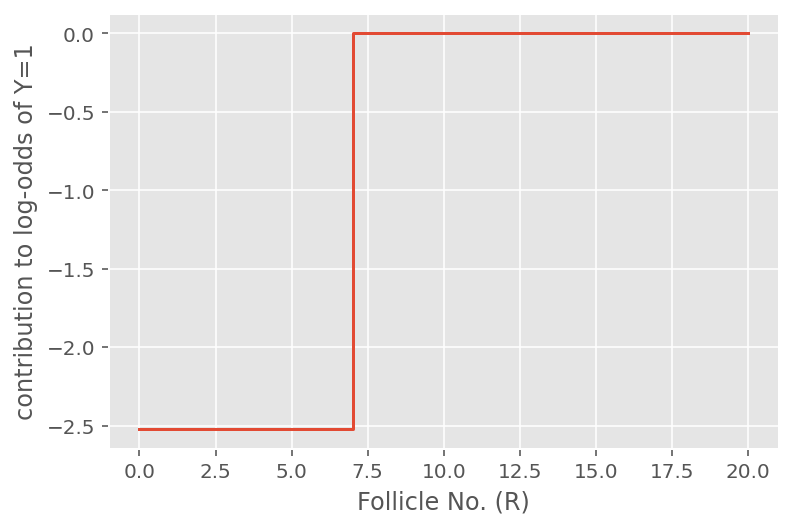

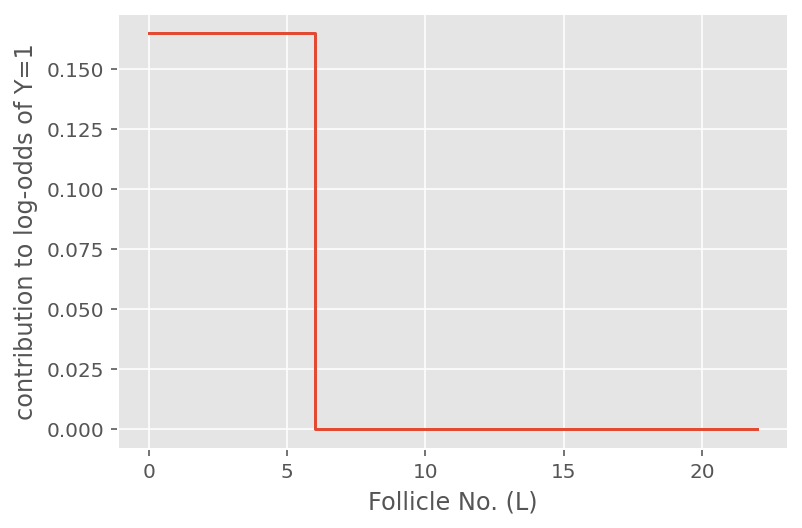

In [22]:
%matplotlib inline

fb = FeatureBinarizer(negations=False)
figs, _ = explainer.visualize(df, fb)